In [1]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np

In [2]:
nlp = spacy.load('es_core_news_sm')

In [3]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop
esp_stop.remove('estado')

In [4]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

In [7]:
def preprocess(df, column):
  articles = df

  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].str.strip()
  articles[column] = articles[column].str.replace('\n', ' ')
  articles[column] = articles[column].str.replace('nº', ' ')
  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
  articles[column] = articles[column].apply(lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize("NFD", x), 0, re.I))

  articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
  return articles.reset_index(drop=True)

### Apertura archivo y preprocesamiento

In [5]:
with open("data/nc_ch_articles.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_art = data.split("--articulo--")

In [6]:
df_art = pd.DataFrame(list_art, columns = ["article"])

In [8]:
df_art_p = preprocess(df_art, "article")

In [9]:
corpus = [word_tokenize(lemmatizer(i)) for i in df_art_p["article"]]

In [10]:
dict_corpus = corpora.Dictionary(corpus)

dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
dtm_gensim_tfidf = models.TfidfModel(dtm_gensim)[dtm_gensim]

In [31]:
lda_gensim = gensim.models.ldamodel.LdaModel
ldamodel_gensim = lda_gensim(
    dtm_gensim_tfidf,
    num_topics = 8,
    passes = 1000,
    id2word = dict_corpus,
    random_state = 0,
    eval_every = None,
    alpha = 'auto'
)

In [32]:
ldamodel_gensim.print_topics(
    num_words = 15,
    num_topics = 8
)

[(0,
  '0.002*"informatico" + 0.001*"reunión" + 0.001*"pacificamente" + 0.001*"maritorio" + 0.001*"pacifico" + 0.001*"cielo" + 0.001*"internacionalmente" + 0.001*"nocturno" + 0.001*"asistido" + 0.001*"deducida" + 0.001*"experto" + 0.001*"consejerio" + 0.001*"resiliencia" + 0.001*"idonea" + 0.001*"atmosfera"'),
 (1,
  '0.004*"derecho" + 0.004*"regional" + 0.004*"estado" + 0.003*"persona" + 0.003*"territorial" + 0.003*"constitucion" + 0.003*"ley" + 0.003*"ser" + 0.003*"tener" + 0.003*"ejercicio" + 0.003*"deber" + 0.003*"cargo" + 0.003*"entidad" + 0.003*"él" + 0.003*"garantizar"'),
 (2,
  '0.006*"agua" + 0.003*"penitenciario" + 0.002*"orientado" + 0.002*"conectividad" + 0.002*"indemnizacion" + 0.001*"asociado" + 0.001*"ocio" + 0.001*"garante" + 0.001*"agencia" + 0.001*"revitalizacion" + 0.001*"sustancia" + 0.001*"habitar" + 0.001*"ambiente" + 0.001*"sano" + 0.001*"descanso"'),
 (3,
  '0.002*"razón" + 0.002*"idioma" + 0.001*"asignir" + 0.001*"campesina" + 0.001*"semilla" + 0.001*"existiran

In [33]:
df_topic_term = pd.DataFrame(
    ldamodel_gensim.get_topics(),
    columns = ldamodel_gensim.id2word.values(),
    index = [f'topic{i}' for i in range(ldamodel_gensim.num_topics)]
)

In [34]:
df_topic_term.sort_values(by = df_topic_term.columns.values.tolist(), ascending = False)

,actividad,asegurar,bien,chile,colectivo,condición,constituir,cultural,deber,democracia,...,quincuagesima,quincuagesimo,rebajar,recaer,reclamacion,reconstruccion,rever,segunir,tipificado,transitarar
topic1,0.001255,0.001617,0.001197,0.001558,0.000645,0.001375,0.000561,0.001499,0.002740,0.000997,...,0.000132,0.000099,0.000064,0.000064,0.000064,0.000082,0.000064,0.000064,0.000064,0.000064
topic0,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,...,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284
topic3,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,...,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276
topic4,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,...,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270
topic6,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,...,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269
topic7,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,...,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266
topic2,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
topic5,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,...,0.000223,0.000223,0.000224,0.000224,0.000224,0.000223,0.000224,0.000224,0.000224,0.000224


In [35]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))  # a measure of how good the model is. lower the better.


Coherence Score:  0.42646933165857004

Perplexity:  -9.466451524619384


In [47]:
def get_max(doc):
    idx, l = zip(*doc)
    return idx[np.argmax(l)] , l[np.argmax(l)]

tpc = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim_tfidf]]
df_tpc = pd.DataFrame(tpc, columns =['topico', 'prop'])
df_tpc['doc'] = df_tpc.index
df_tpc[df_tpc["topico"]==1].sort_values('prop',ascending=False).head()

,topico,prop,doc
387,1,0.948028,387
285,1,0.941650,285
262,1,0.938928,262
251,1,0.938033,251
389,1,0.937074,389


In [48]:
df_art_p['article'][387]

'de la ley cuyo texto refundido coordinado y sistematizado fue fijado por el decreto con fuerza de ley de del ministerio secretaria general de la presidencia d para garantizar el equilibrio de genero se aplicara a la declaracion de candidaturas para las elecciones de los organos de representacion popular lo establecido en la disposicion transitoria trigesima de la constitucion anterior conforme con lo señalado por el articulo asimismo para garantizar la integracion paritaria de genero en las elecciones de cada distrito region y comuna se aplicara lo dispuesto en el numero de la disposicion transitoria trigesima primera de la constitucion anterior siguiendo el mandato contenido en el articulo inciso solo en el caso de la camara de las regiones dicha normativa se aplicara cuando su composicion nacional no cumpla con la integracion paritaria caso en el cual la correccion de genero se aplicara comenzando por la region en que se haya asignado un escaño al candidato porcentualmente menos v

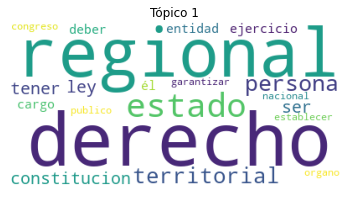

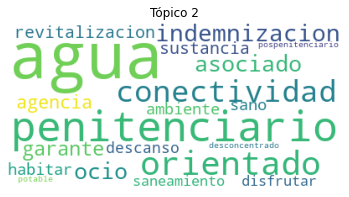

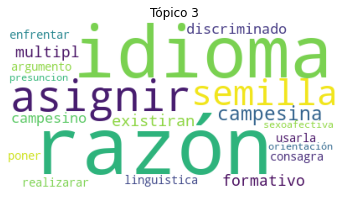

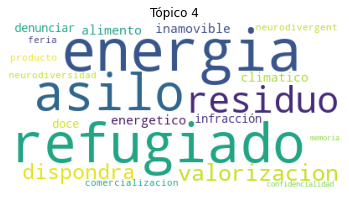

In [40]:
for i in range(1, 5):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim.show_topic(i, 20)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()